Saving chicago.jpg to chicago (2).jpg
Saving waterlillies.jpg to waterlillies (2).jpg
Iteration 0, Loss: 1483501.0


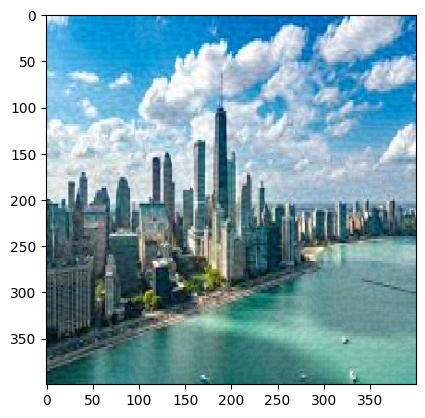

Iteration 100, Loss: 454671.8125


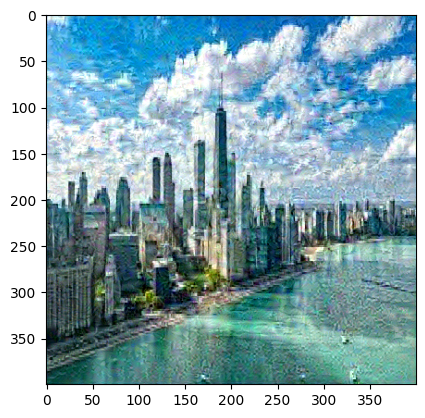

Iteration 200, Loss: 350913.9375


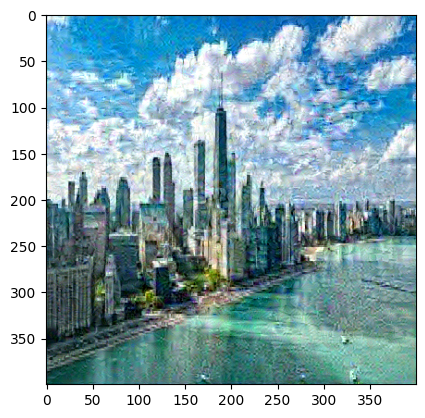

Iteration 300, Loss: 311084.625


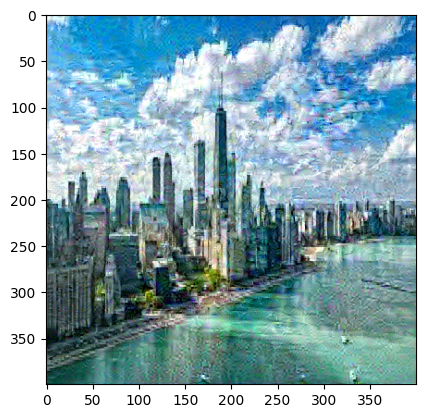

Iteration 400, Loss: 367074.53125


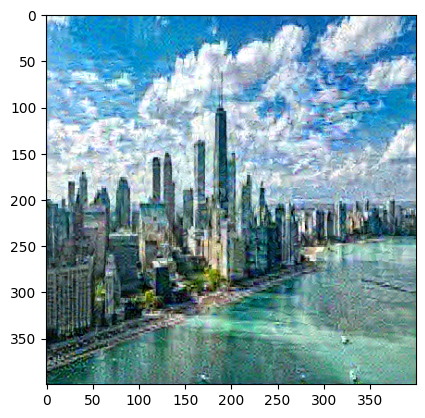

Iteration 500, Loss: 285691.96875


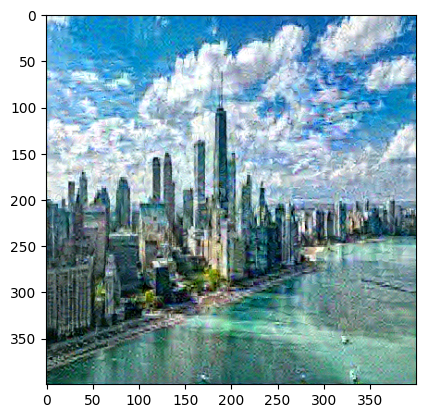

Iteration 600, Loss: 314332.34375


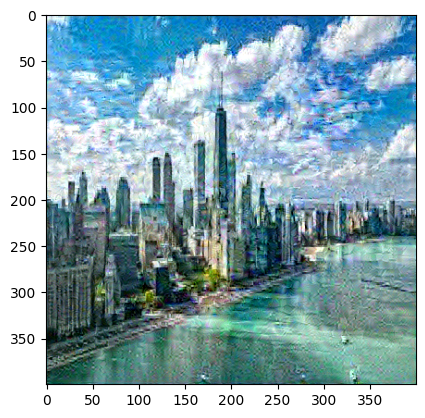

Iteration 700, Loss: 263332.6875


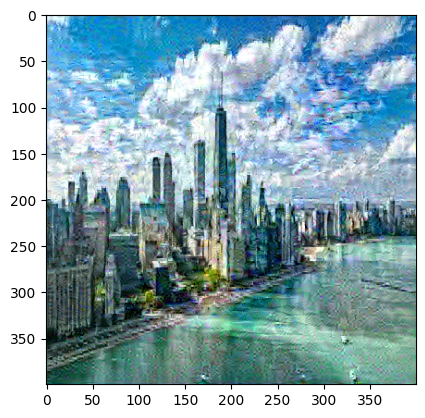

Iteration 800, Loss: 253144.03125


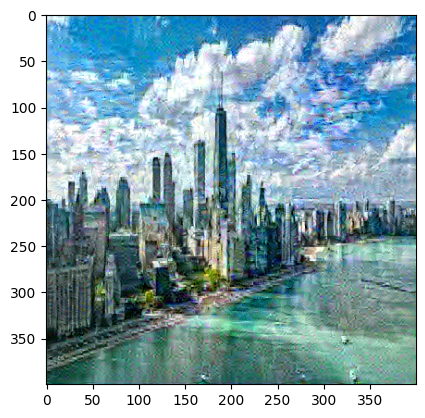

Iteration 900, Loss: 446153.46875


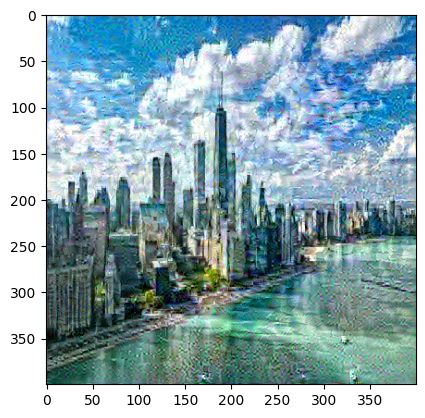

Iteration 1000, Loss: 224826.96875


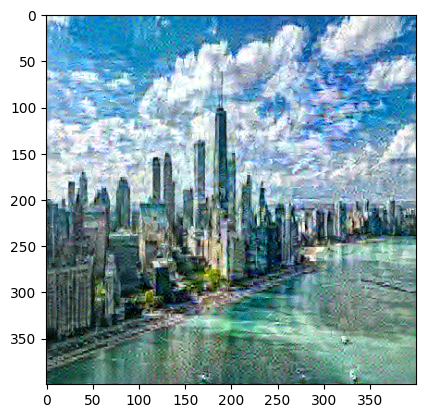

Iteration 1100, Loss: 257858.59375


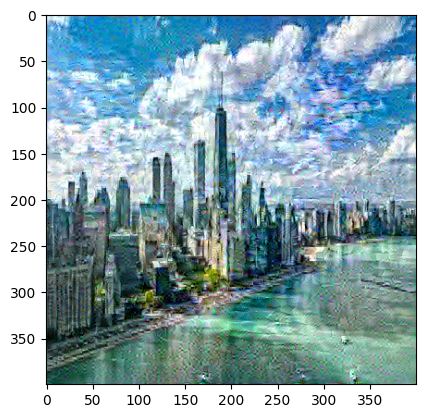

Iteration 1200, Loss: 297906.6875


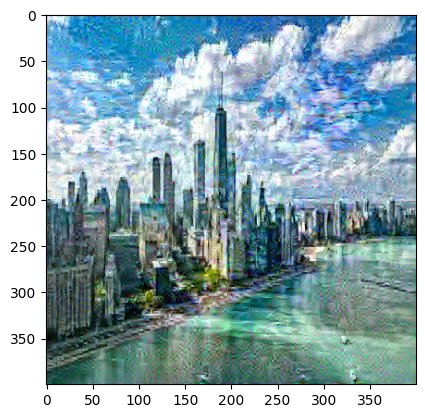

Iteration 1300, Loss: 221477.65625


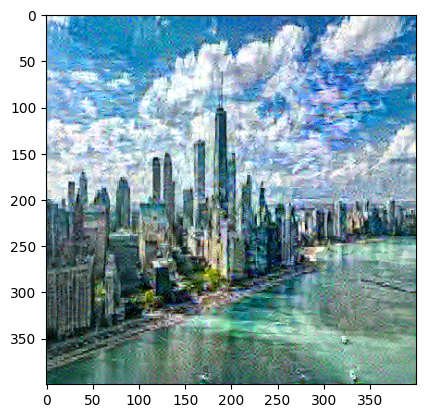

Iteration 1400, Loss: 808224.1875


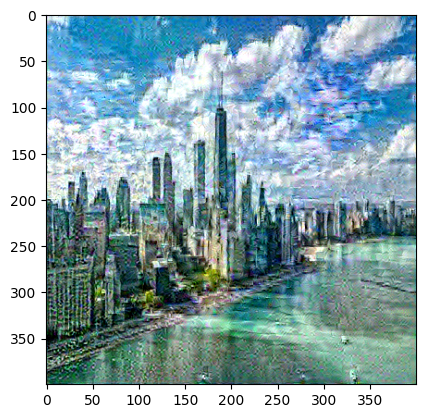

Iteration 1500, Loss: 239939.953125


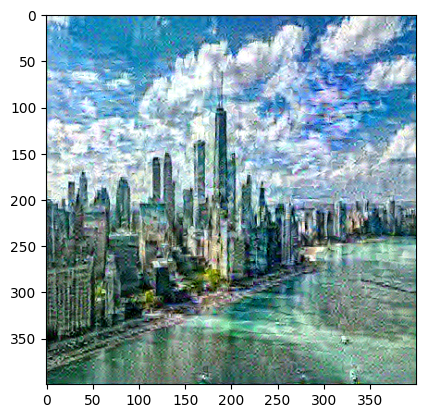

Iteration 1600, Loss: 216882.4375


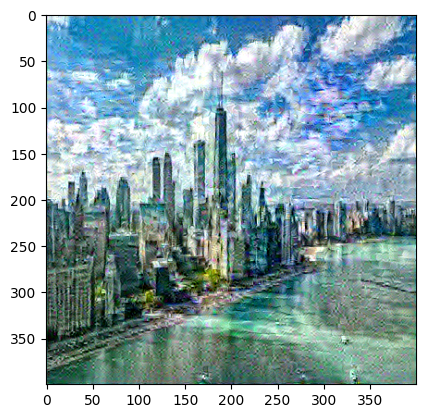

Iteration 1700, Loss: 203527.5625


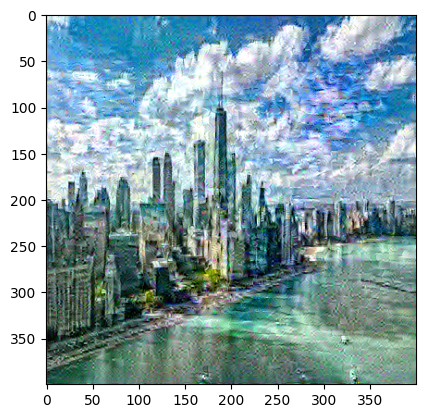

Iteration 1800, Loss: 216109.953125


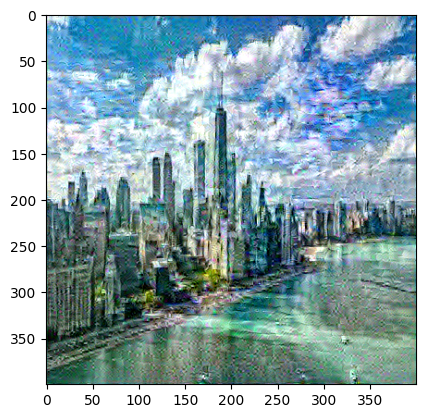

Iteration 1900, Loss: 208562.90625


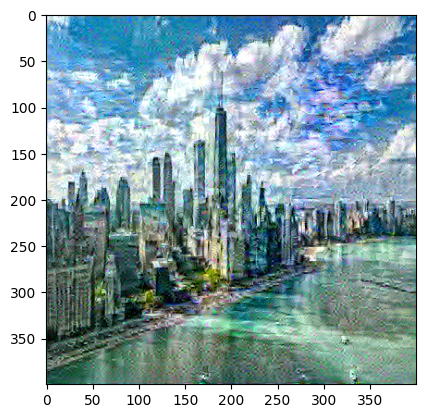

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files


uploaded = files.upload()

content_image_path = list(uploaded.keys())[0]   #(content)
style_image_path = list(uploaded.keys())[1]    # (style)


def load_and_process_image(image_path):
    img = load_img(image_path, target_size=(400, 400))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(processed_image):
    x = processed_image.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

vgg = VGG19(include_top=False, weights='imagenet')


content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

def get_model():
    outputs = [vgg.get_layer(name).output for name in style_layers] + [vgg.get_layer(content_layer).output]
    model = Model([vgg.input], outputs)
    return model


def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def compute_style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    return tf.reduce_mean(tf.square(S - C))

def compute_content_loss(content, combination):
    return tf.reduce_mean(tf.square(content - combination))

content_weight = 1e3
style_weight = 1e-2

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)
    style_output_features = model_outputs[:len(style_layers)]
    content_output_features = model_outputs[len(style_layers):]
    style_score = 0
    content_score = 0

    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += compute_style_loss(target_style, comb_style)

    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += compute_content_loss(target_content, comb_content)

    style_score *= style_weight / len(style_layers)
    content_score *= content_weight
    loss = style_score + content_score
    return loss

optimizer = tf.optimizers.Adam(learning_rate=5.0)

@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss
    return tape.gradient(total_loss, cfg['init_image']), all_loss

def style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):


    content_image = load_and_process_image(content_path)
    style_image = load_and_process_image(style_path)

    model = get_model()
    style_features = [style_layer for style_layer in model(style_image)[:len(style_layers)]]
    content_features = [content_layer for content_layer in model(content_image)[len(style_layers):]]

    init_image = tf.Variable(content_image, dtype=tf.float32)

    loss_weights = (style_weight, content_weight)

    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': style_features,
        'content_features': content_features
    }

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        optimizer.apply_gradients([(grads, init_image)])

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {all_loss}")
            img = deprocess_image(init_image.numpy())
            plt.imshow(img)
            plt.show()

    return deprocess_image(init_image.numpy())


output_image = style_transfer(content_image_path, style_image_path, num_iterations=2000, content_weight=1e4, style_weight=1e-4)



In [1]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))



GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
